In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import networkx as nx
from matplotlib import cm
jax.config.update("jax_enable_x64", True)
fix_lock_run_csv = pd.read_csv('fix_lock_loss_vs_iter.csv')
trainable_lock_run_csv = pd.read_csv('trainable_lock_loss_vs_iter.csv')

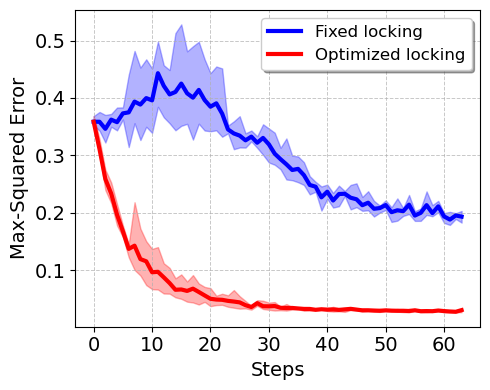

In [2]:
# Visualze Training Loss
# Remove the columns ends with _MAX or _MIN and remove Step column
def remove_redudant_columns(run_csv):
    run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('_MAX')]
    run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('_MIN')]
    run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('Step')]
    return run_csv

# X-axis: Steps
# Y-axis: Max-Squared Error
# Line: Mean and shaded area for the min/max
# Two lines: One for each run

fix_lock_run_csv = remove_redudant_columns(fix_lock_run_csv)
trainable_lock_run_csv = remove_redudant_columns(trainable_lock_run_csv)
plt.figure(figsize=(5, 4))  # Set a larger figure size

for run, label, color in zip([fix_lock_run_csv, trainable_lock_run_csv], ["Fixed locking", "Optimized locking"], ["blue", "red"]):
    mean = run.mean(axis=1)
    run_min = run.min(axis=1)
    run_max = run.max(axis=1)

    # Plot the mean and standard deviation
    steps = np.arange(0, len(mean))

    # Plotting
    plt.plot(steps, mean, label=label, color=color, linewidth=3)  # Thicker line
    plt.fill_between(steps, run_min, run_max, color=color, alpha=0.3)

# Enhancing aesthetics
plt.xlabel('Steps', fontsize=14)  # Larger label font size
plt.ylabel('Max-Squared Error', fontsize=14)  # Larger label font size

# Adjust tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid with a finer style
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Modify legend
plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.savefig('obc_loss_vs_iter.pdf', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_85185/679904148.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')


[3.05831308]


/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_85185/679904148.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


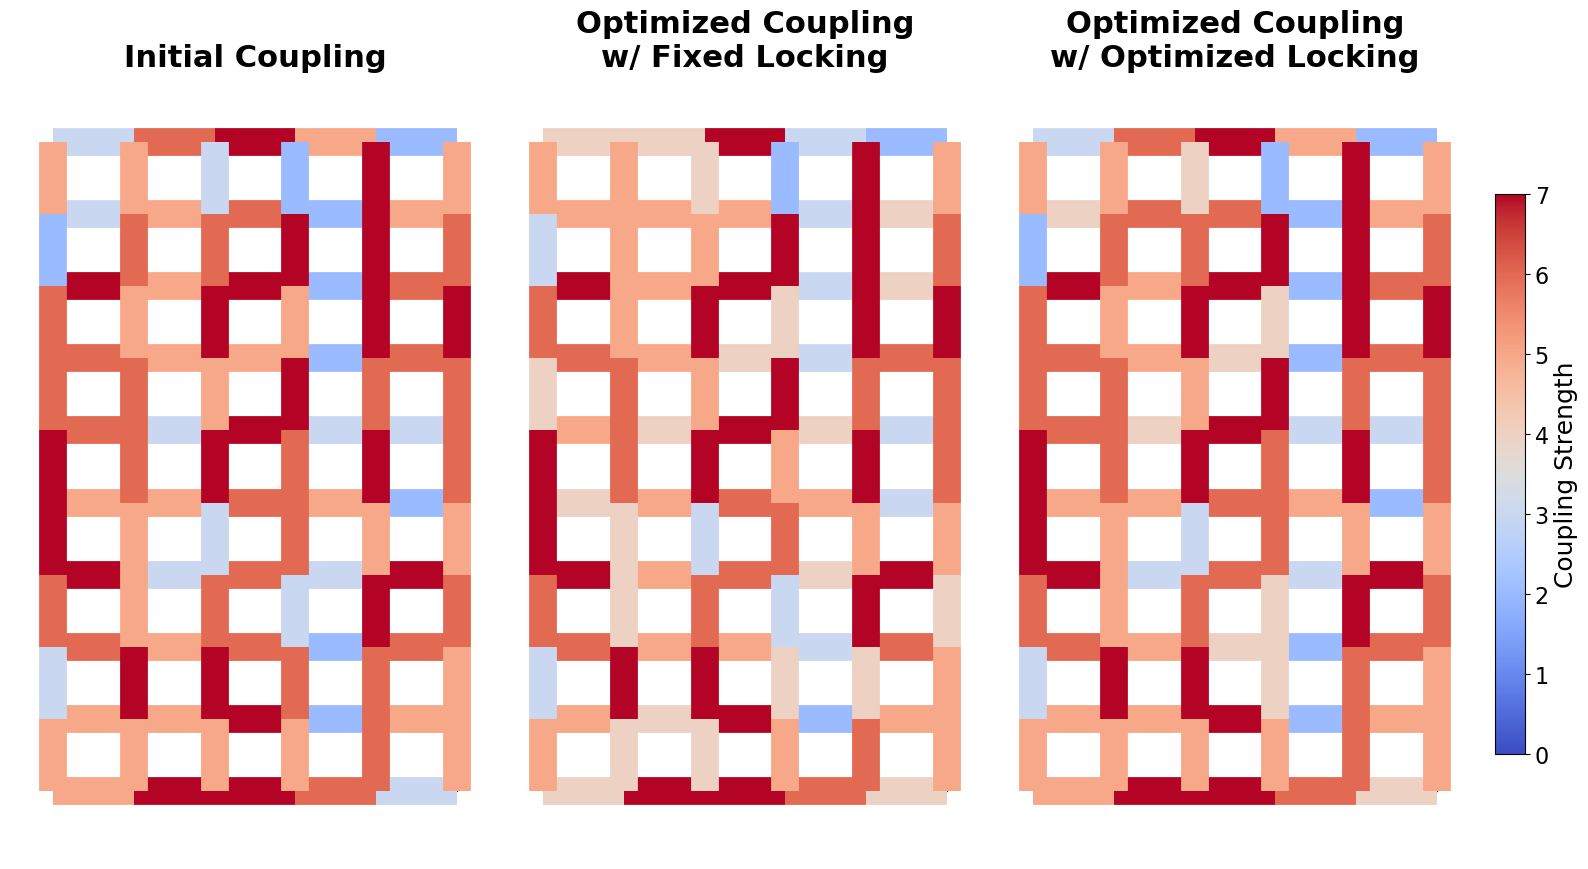

In [89]:
# Visualize the coupling strength

# Use a single color map for both row and column weights
cmap = cm.get_cmap('coolwarm')
weight_min, weight_max = 0, 7

# Normalize weights for consistent coloring across all coupling strengths
norm = plt.Normalize(vmin=weight_min, vmax=weight_max)

def plot_grid_with_weights(row_weights, column_weights, ax, cmap=cmap, norm=norm):
    # Create a 10x6 grid graph
    rows, cols = 10, 6
    G = nx.grid_2d_graph(rows, cols)

    # Position the nodes in a grid layout
    pos = {(i, j): (j, -i) for i in range(rows) for j in range(cols)}

    # Draw the nodes as small dots
    nx.draw(G, pos, node_size=0, node_color='black', with_labels=False, ax=ax)

    # Draw horizontal edges with row weights (colored by normalized weight)
    for i in range(rows):
        for j in range(cols - 1):
            edge = ((i, j), (i, j + 1))
            weight = row_weights[i, j]
            G.edges[edge]['color'] = cmap(norm(weight))
            G.edges[edge]['weight'] = weight
            nx.draw_networkx_edges(G, pos, edgelist=[edge], width=20, edge_color=[G.edges[edge]['color']], ax=ax)

    # Draw vertical edges with column weights (colored by normalized weight)
    for i in range(rows - 1):
        for j in range(cols):
            edge = ((i, j), (i + 1, j))
            weight = column_weights[i, j]
            G.edges[edge]['color'] = cmap(norm(weight))
            G.edges[edge]['weight'] = weight
            nx.draw_networkx_edges(G, pos, edgelist=[edge], width=20, edge_color=[G.edges[edge]['color']], ax=ax)


def convert_weights(w: jnp.ndarray):
    # Weight consists of:
    # 1. flattened 10x5 vector for the coupling in every row, plus
    # 2. flattened 9x6 vector for the coupling in every column
    # The element in the vector is an one-hot encoding of the coupling strength
    # where the index with the highest value is the coupling strength

    row_ks = w[:50].reshape(10, 5, -1).argmax(axis=2)
    col_ks = w[50:].reshape(9, 6, -1).argmax(axis=2)

    return row_ks, col_ks

# Create a figure with 3 subplots
# Init_weight, Fixed locking, Optimized locking

fig, ax = plt.subplots(1, 3, figsize=(15, 8))

init_weight_file = "weights/init_weight.npz"
weights = jnp.load(init_weight_file)
init_row_ks, init_col_ks = convert_weights(weights["digital"])
plot_grid_with_weights(init_row_ks, init_col_ks, ax[0])
ax[0].set_title("Initial Coupling", fontsize=22, fontweight='bold')

# Fixed locking
for seed in range(1):
    weight_file = f"weights/{seed}.npz"
    weights = jnp.load(weight_file)
    row_ks, col_ks = convert_weights(weights["digital"])
    plot_grid_with_weights(row_ks, col_ks, ax[1])
ax[1].set_title("Optimized Coupling\nw/ Fixed Locking", fontsize=22, fontweight='bold')

# Optimized locking
for seed in range(1):
    weight_file = f"weights/train_locking_{seed}.npz"
    weights = jnp.load(weight_file)
    row_ks, col_ks = convert_weights(weights["digital"])
    plot_grid_with_weights(row_ks, col_ks, ax[2])
    print(weights["analog"])
ax[2].set_title("Optimized Coupling\nw/ Optimized Locking", fontsize=22, fontweight='bold')



# Create a single shared colorbar for both row and column weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.axis('off')
# Add the colorbar to the figure
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Coupling Strength', fontsize=18)

# Final adjustments and display
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0, top=1)  # Adjust spacing between subplots
plt.savefig('obc_weight.pdf', dpi=300, bbox_inches='tight')
plt.show()




/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_85185/1629408779.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')
/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_85185/1629408779.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


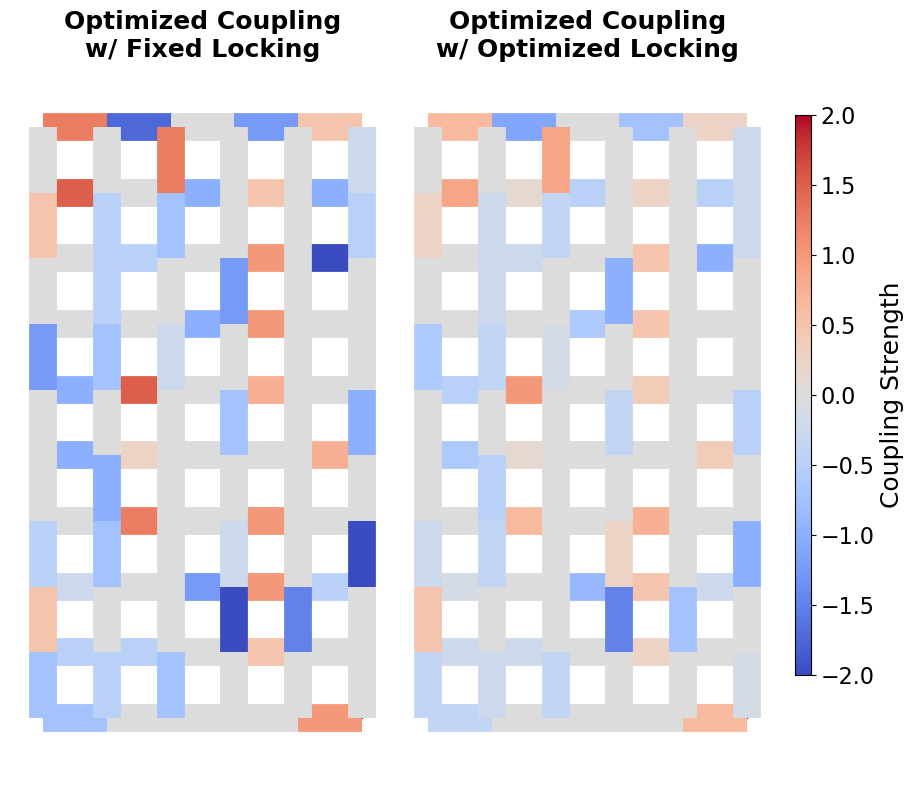

In [93]:
# Plot the diff of the grid

n_seeds = 4

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
# cmap = cm.get_cmap('Reds')
cmap = cm.get_cmap('coolwarm')


# Fixed locking
abs_row_diffs, abs_col_diffs = [], []
for seed in range(n_seeds):
    weight_file = f"weights/{seed}.npz"
    weights = jnp.load(weight_file)
    row_ks, col_ks = convert_weights(weights["digital"])
    abs_row_diffs.append(row_ks - init_row_ks)
    abs_col_diffs.append(col_ks - init_col_ks)

mean_row_diffs = jnp.mean(jnp.stack(abs_row_diffs), axis=0)
mean_col_diffs = jnp.mean(jnp.stack(abs_col_diffs), axis=0)

# Lazy: Fixed locking produce higher strength difference
# So we use the max and min of the fixed locking for the color normalization
weight_max = max(mean_row_diffs.max(), mean_col_diffs.max())
weight_min = min(mean_row_diffs.min(), mean_col_diffs.min())

# Make the upper and lower bound center around 0
weight_max = max(abs(weight_max), abs(weight_min))
weight_min = -weight_max
norm = plt.Normalize(vmin=weight_min, vmax=weight_max)

plot_grid_with_weights(mean_row_diffs, mean_col_diffs, ax[0], cmap, norm)
ax[0].set_title("Optimized Coupling\nw/ Fixed Locking", fontsize=18, fontweight='bold')

# Optimized locking
for seed in range(n_seeds):
    weight_file = f"weights/train_locking_{seed}.npz"
    weights = jnp.load(weight_file)
    row_ks, col_ks = convert_weights(weights["digital"])
    abs_row_diffs.append(row_ks - init_row_ks)
    abs_col_diffs.append(col_ks - init_col_ks)


mean_row_diffs = jnp.mean(jnp.stack(abs_row_diffs), axis=0)
mean_col_diffs = jnp.mean(jnp.stack(abs_col_diffs), axis=0)
plot_grid_with_weights(mean_row_diffs, mean_col_diffs, ax[1], cmap, norm)
ax[1].set_title("Optimized Coupling\nw/ Optimized Locking", fontsize=18, fontweight='bold')

# Create a single shared colorbar for both row and column weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.axis('off')
# Add the colorbar to the figure
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Coupling Strength', fontsize=18)

# Final adjustments and display
plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)  # Adjust spacing between subplots
plt.savefig('obc_weight_diff.pdf', dpi=300, bbox_inches='tight')

plt.show()